In [1]:
import os
import urllib
import hashlib
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.patches as patches
from sklearn.linear_model import LogisticRegression
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.patches as patches
import pytz

import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [2]:
years = range(2009, 2024)

In [3]:
for year in years:
    if not os.path.exists(f'../.cache/pbp/season={year}'):
        nfl.cache_pbp(years=[year], alt_path='../.cache/pbp', downcast=True)

df_pbp = nfl.import_pbp_data(years, cache=True, alt_path='../.cache/pbp').reset_index(drop=True)

df_schedules = nfl.import_schedules(years).reset_index(drop=True)

df_stadiums_locs = pd.read_csv('../data/stadiums.csv')[['stadium_id','lat','lon','timezone']]

df_elevations = pd.read_csv('../data/stadium_elevation.csv')

cols = ['season','player_id','player_name','years_exp','draft_number','age']
df_rosters = nfl.import_seasonal_rosters(years)[cols]

2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
df_pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [5]:
# Columns to keep
variables = [
    'season', 'game_id', 'play_id', 'week', 'home_team', 'away_team', 'kicker_player_name', 'kicker_player_id', 
    'field_goal_attempt', 'field_goal_result', 'kick_distance', 'game_seconds_remaining',
    'game_half', 'season_type', 'posteam_type', 'roof', 'surface', 'wind', 'temp', 'stadium_id',
    'score_differential', 'timeout_prev_play', 'timeout_team_prev_play', 'posteam'
] # score_differential = posteam_score - defteam_score

# Sort by game_id and play_id and create columns for previous play's timeout and description
df_pbp = df_pbp.sort_values(['game_id', 'play_id'])
df_pbp['timeout_prev_play'] = df_pbp['timeout'].shift(1)
df_pbp['timeout_team_prev_play'] = df_pbp['timeout_team'].shift(1)
df_pbp['desc_prev_play'] = df_pbp['desc'].shift(1)

# Filter for field goal attempts
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

# Fix missing timeout team data for specific plays
fixes = {
    ('2013_07_SD_JAX', 2389.0): 'JAX',
    ('2015_09_JAX_NYJ', 2731.0): 'JAX'
}
for (game_id, play_id), team in fixes.items():
    df_fg.loc[(df_fg.play_id == play_id) & (df_fg.game_id == game_id), 'timeout_team_prev_play'] = team

# Determine if kicker was iced
df_fg['iced'] = np.where(
    (df_fg['timeout_prev_play'] == True) & (df_fg['posteam'] != df_fg['timeout_team_prev_play']), 
    1, 
    0
)

# Create binary columns for various conditions
df_fg['overtime'] = (df_fg['game_half'] == 'Overtime').astype(int)
df_fg['postseason'] = (df_fg['season_type'] == 'POST').astype(int)
df_fg['home_stadium'] = (df_fg['posteam_type'] == 'home').astype(int)
df_fg['grass_field'] = (df_fg['surface'] == 'grass').astype(int)
df_fg['grass_surface'] = df_fg['surface'].isin(['grass', 'grass ', 'dessograss']).astype(int)
df_fg['outdoors'] = (df_fg['roof'].isin(['outdoors', 'open'])).astype(int)

# Handle missing temperature and wind data
df_fg['temp'] = df_fg['temp'].fillna(70)
df_fg['wind'] = df_fg['wind'].fillna(0)

# Fill missing surface data based on the most common surface for each stadium
stadiums_with_surface = df_fg.query('surface == ""').stadium_id.unique()
for stadium_id in stadiums_with_surface:
    v_counts = df_fg.query('stadium_id == @stadium_id').surface.value_counts()
    surface = v_counts.index[0] 
    if (surface == "") & (len(v_counts) > 1):
        surface = v_counts.index[1]
    df_fg.loc[(df_fg.stadium_id == stadium_id) & (df_fg.surface == ""), 'surface'] = surface

# Special case for a specific stadium
df_fg.loc[df_fg.stadium_id == "GER00", 'surface'] = "dessograss"

# Merge stadium elevations
df_fg = df_fg.merge(df_elevations, how='left', on='stadium_id')

# Create a binary column for field goal made
df_fg['field_goal_made'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

df_fg = df_fg.merge(df_schedules[['game_id', 'gameday', 'gametime']], on='game_id', how='left')

df_fg = df_fg.merge(df_stadiums_locs, how='left', on='stadium_id')

# Find the stadium elevation for the kicker's home stadium
home_stadiums = (df_schedules[['season', 'home_team', 'stadium_id']]
    .groupby(['season', 'home_team'])
    .agg(total=('stadium_id', 'count'), 
         home_stadium=('stadium_id', lambda x: x.value_counts().index[0]))
    .reset_index()
    .sort_values('total', ascending=True)
    [['season', 'home_team', 'home_stadium']]
    .merge(df_elevations, how='left', left_on='home_stadium', right_on='stadium_id')
    .drop(['stadium_id','home_stadium'], axis=1)
    .rename({'elevation':'home_stadium_elevation', 'home_team':'team'}, axis=1)
)
df_fg = df_fg.merge(home_stadiums, how='left', left_on=['season', 'posteam'], right_on=['season', 'team'])

df_fg['elevation_diff'] = df_fg['elevation'] - df_fg['home_stadium_elevation']

# Convert start time to datetime and convert to local time
def convert_timezone(row):
    return row['start_time'].tz_convert(pytz.timezone(row['timezone']))
df_fg['start_time'] = pd.to_datetime(df_fg.gameday + ' ' + df_fg.gametime, format='%Y-%m-%d %H:%M')
df_fg['start_time'] = df_fg['start_time'].dt.tz_localize(pytz.timezone('US/Eastern'))
df_fg['start_time'] = df_fg.apply(convert_timezone, axis=1)

# Join the roster data
df_fg = df_fg.merge(df_rosters, how='left', left_on=['season', 'kicker_player_id'], right_on=['season', 'player_id'])

pressure_situations = df_fg.overtime | \
    ((df_fg.score_differential <= 0) & (df_fg.score_differential >= -3) & (df_fg.game_seconds_remaining <= 500)) | \
    ((df_fg.postseason == 1) & (df_fg.score_differential <= 0) & (df_fg.score_differential >= -3)) | \
    (df_fg.iced == 1)

df_fg['pressure_situation'] = pressure_situations.astype(int)

# Drop unnecessary columns
drop_cols = [
    'kicker_player_name','game_half', 'season_type', 'posteam_type', 'surface', 'roof',
    'timeout_prev_play', 'timeout_team_prev_play', 'field_goal_result', 
    'field_goal_attempt', 'stadium_id', 'gameday', 'gametime', 'lat', 'lon', 'timezone', 'home_stadium_elevation',
    'start_time', 'player_id', 'team', 'posteam'
]

# Reorder columns
df_fg = df_fg[df_fg.columns.drop('player_name').insert(df_fg.columns.get_loc('kicker_player_id') - 1, 'player_name')]
df_fg = df_fg[df_fg.columns.drop('field_goal_made').insert(len(df_fg.columns)-1, 'field_goal_made')]
df_fg = df_fg[df_fg.columns.drop('years_exp').insert(df_fg.columns.get_loc('kicker_player_id') + 1, 'years_exp')]
df_fg = df_fg[df_fg.columns.drop('draft_number').insert(df_fg.columns.get_loc('kicker_player_id') + 2, 'draft_number')]
df_fg = df_fg[df_fg.columns.drop('age').insert(df_fg.columns.get_loc('kicker_player_id') + 3, 'age')]
df_fg = df_fg.drop(drop_cols, axis=1)

In [6]:
nfl_teams = {
    'NE': 'Patriots',
    'GB': 'Packers',
    'TB': 'Buccaneers',
    'CIN': 'Bengals',
    'NO': 'Saints',
    'IND': 'Colts',
    'BAL': 'Ravens',
    'ATL': 'Falcons',
    'CLE': 'Browns',
    'HOU': 'Texans',
    'CAR': 'Panthers',
    'LV': 'Raiders',
    'ARI': 'Cardinals',
    'SEA': 'Seahawks',
    'PIT': 'Steelers',
    'NYG': 'Giants',
    'JAX': 'Jaguars',
    'LAC': 'Chargers',
    'DEN': 'Broncos',
    'TEN': 'Titans',
    'MIA': 'Dolphins',
    'DET': 'Lions',
    'NYJ': 'Jets',
    'PHI': 'Eagles',
    'DAL': 'Cowboys',
    'KC': 'Chiefs',
    'CHI': 'Bears',
    'SF': '49ers',
    'WAS': 'Washington',
    'BUF': 'Bills',
    'LA': 'Rams',
    'MIN': 'Vikings'
}

df_schedules['home_team_name'] = df_schedules['home_team'].map(nfl_teams)
df_schedules['away_team_name'] = df_schedules['away_team'].map(nfl_teams)

In [27]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import re


# Initialize tqdm with pandas
tqdm.pandas()

def get_weather_descriptions(season, week, away_team, home_team):
    if away_team == 'Washington':
        away_team = 'Redskins'
    if home_team == 'Washington':
        home_team = 'Redskins'
    
    url = f'https://www.nflweather.com/games/{season}/week-{week}/{away_team}-at-{home_team}'
    print(url)
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Initialize weather descriptions
        kickoff_weather = None
        q2_weather = None
        q3_weather = None
        q4_weather = None
        kickoff_visibility = None
        q2_visibility = None
        q3_visibility = None
        q4_visibility = None
        
        # Find all weather titles
        weather_titles = soup.find_all('h3', class_='text-center my-2 weather-title')
        
        for weather_title in weather_titles:
            # Check if the title is for Kickoff
            if 'Kickoff' in weather_title.text:
                weather_div = weather_title.find_parent('div', class_='col-6 col-xl-12 col-xxl-6 text-center')
                weather_span = weather_div.find('span') if weather_div else None
                kickoff_weather = weather_span.text.strip() if weather_span else None
                parent_weather_div = weather_div.find_parent('div', class_='d-flex flex-xl-column flex-xxl-row my-3')
                next_weather_div = parent_weather_div.find_next_sibling('div', class_='d-flex flex-wrap mt-auto weather-data-container')
                # find p tag with a span that contains the word "Visibility", the value is after that word like "Visibility: 10 m"
                for p_tag in next_weather_div.find_all('p', class_='weather-data'):
                    if 'Visibility' in p_tag.text:
                        kickoff_visibility = re.search(r'\d+', p_tag.find('span').next_sibling.strip())
                        if kickoff_visibility:
                            kickoff_visibility = int(kickoff_visibility.group())
                        break
            
            # Check if the title is for Q2
            if 'Q2' in weather_title.text:
                weather_div = weather_title.find_parent('div', class_='col-6 col-xl-12 col-xxl-6 text-center')
                weather_span = weather_div.find('span') if weather_div else None
                q2_weather = weather_span.text.strip() if weather_span else None
                parent_weather_div = weather_div.find_parent('div', class_='d-flex flex-xl-column flex-xxl-row my-3')
                next_weather_div = parent_weather_div.find_next_sibling('div', class_='d-flex flex-wrap mt-auto weather-data-container')
                # find p tag with a span that contains the word "Visibility", the value is after that word like "Visibility: 10 m"
                for p_tag in next_weather_div.find_all('p', class_='weather-data'):
                    if 'Visibility' in p_tag.text:
                        q2_visibility = re.search(r'\d+', p_tag.find('span').next_sibling.strip())
                        if q2_visibility:
                            q2_visibility = int(q2_visibility.group())
                        break

            # Check if the title is for Q3
            if 'Q3' in weather_title.text:
                weather_div = weather_title.find_parent('div', class_='col-6 col-xl-12 col-xxl-6 text-center')
                weather_span = weather_div.find('span') if weather_div else None
                q3_weather = weather_span.text.strip() if weather_span else None
                parent_weather_div = weather_div.find_parent('div', class_='d-flex flex-xl-column flex-xxl-row my-3')
                next_weather_div = parent_weather_div.find_next_sibling('div', class_='d-flex flex-wrap mt-auto weather-data-container')
                # find p tag with a span that contains the word "Visibility", the value is after that word like "Visibility: 10 m"
                for p_tag in next_weather_div.find_all('p', class_='weather-data'):
                    if 'Visibility' in p_tag.text:
                        q3_visibility = re.search(r'\d+', p_tag.find('span').next_sibling.strip())
                        if q3_visibility:
                            q3_visibility = int(q3_visibility.group())
                        break

            # Check if the title is for Q4
            if 'Q4' in weather_title.text:
                weather_div = weather_title.find_parent('div', class_='col-6 col-xl-12 col-xxl-6 text-center')
                weather_span = weather_div.find('span') if weather_div else None
                q4_weather = weather_span.text.strip() if weather_span else None
                parent_weather_div = weather_div.find_parent('div', class_='d-flex flex-xl-column flex-xxl-row my-3')
                next_weather_div = parent_weather_div.find_next_sibling('div', class_='d-flex flex-wrap mt-auto weather-data-container')
                # find p tag with a span that contains the word "Visibility", the value is after that word like "Visibility: 10 m"
                for p_tag in next_weather_div.find_all('p', class_='weather-data'):
                    if 'Visibility' in p_tag.text:
                        q4_visibility = re.search(r'\d+', p_tag.find('span').next_sibling.strip())
                        if q4_visibility:
                            q4_visibility = int(q4_visibility.group())
                        break
        
        return kickoff_weather, q2_weather, q3_weather, q4_weather, kickoff_visibility, q2_visibility, q3_visibility, q4_visibility
    
    except Exception as e:
        print(e)

# Apply the function to each row with progress tracking
cols = ['kickoff_weather','q2_weather','q3_weather','q4_weather','kickoff_visibility','q2_visibility','q3_visibility','q4_visibility']
df_schedules.iloc[120:].head(150).progress_apply(
    lambda x: pd.Series(get_weather_descriptions(x['season'], x['week'], x['away_team_name'], x['home_team_name'])),
    axis=1
)

  0%|          | 0/150 [00:00<?, ?it/s]

https://www.nflweather.com/games/2009/week-9/Chiefs-at-Jaguars


  1%|▏         | 2/150 [00:00<00:20,  7.16it/s]

https://www.nflweather.com/games/2009/week-9/Dolphins-at-Patriots


  2%|▏         | 3/150 [00:00<00:28,  5.18it/s]

https://www.nflweather.com/games/2009/week-9/Packers-at-Buccaneers


  3%|▎         | 4/150 [00:00<00:32,  4.45it/s]

https://www.nflweather.com/games/2009/week-9/Panthers-at-Saints


  3%|▎         | 5/150 [00:01<00:36,  4.01it/s]

https://www.nflweather.com/games/2009/week-9/Lions-at-Seahawks


  4%|▍         | 6/150 [00:01<00:37,  3.88it/s]

https://www.nflweather.com/games/2009/week-9/nan-at-Giants


  5%|▍         | 7/150 [00:01<00:38,  3.67it/s]

https://www.nflweather.com/games/2009/week-9/Titans-at-49ers


  5%|▌         | 8/150 [00:01<00:38,  3.71it/s]

https://www.nflweather.com/games/2009/week-9/Cowboys-at-Eagles


  6%|▌         | 9/150 [00:02<00:38,  3.71it/s]

https://www.nflweather.com/games/2009/week-9/Steelers-at-Broncos


  7%|▋         | 10/150 [00:02<00:37,  3.74it/s]

https://www.nflweather.com/games/2009/week-10/Bears-at-49ers


  7%|▋         | 11/150 [00:02<00:36,  3.78it/s]

https://www.nflweather.com/games/2009/week-10/Falcons-at-Panthers


  8%|▊         | 12/150 [00:03<00:36,  3.81it/s]

https://www.nflweather.com/games/2009/week-10/Buccaneers-at-Dolphins


  9%|▊         | 13/150 [00:03<00:35,  3.81it/s]

https://www.nflweather.com/games/2009/week-10/Lions-at-Vikings


  9%|▉         | 14/150 [00:03<00:35,  3.83it/s]

https://www.nflweather.com/games/2009/week-10/Jaguars-at-Jets


 10%|█         | 15/150 [00:03<00:35,  3.81it/s]

https://www.nflweather.com/games/2009/week-10/Bengals-at-Steelers


 11%|█         | 16/150 [00:04<00:35,  3.83it/s]

https://www.nflweather.com/games/2009/week-10/Saints-at-nan


 11%|█▏        | 17/150 [00:04<00:36,  3.63it/s]

https://www.nflweather.com/games/2009/week-10/Bills-at-Titans


 12%|█▏        | 18/150 [00:04<00:35,  3.70it/s]

https://www.nflweather.com/games/2009/week-10/Broncos-at-Redskins


 13%|█▎        | 19/150 [00:04<00:35,  3.74it/s]

https://www.nflweather.com/games/2009/week-10/Chiefs-at-nan


 13%|█▎        | 20/150 [00:05<00:36,  3.54it/s]

https://www.nflweather.com/games/2009/week-10/Seahawks-at-Cardinals


 14%|█▍        | 21/150 [00:05<00:35,  3.61it/s]

https://www.nflweather.com/games/2009/week-10/Cowboys-at-Packers


 15%|█▍        | 22/150 [00:05<00:34,  3.67it/s]

https://www.nflweather.com/games/2009/week-10/Eagles-at-nan


 15%|█▌        | 23/150 [00:06<00:36,  3.51it/s]

https://www.nflweather.com/games/2009/week-10/Patriots-at-Colts


 16%|█▌        | 24/150 [00:06<00:35,  3.58it/s]

https://www.nflweather.com/games/2009/week-10/Ravens-at-Browns


 17%|█▋        | 25/150 [00:06<00:34,  3.66it/s]

https://www.nflweather.com/games/2009/week-11/Dolphins-at-Panthers


 17%|█▋        | 26/150 [00:06<00:33,  3.70it/s]

https://www.nflweather.com/games/2009/week-11/Colts-at-Ravens


 18%|█▊        | 27/150 [00:07<00:32,  3.74it/s]

https://www.nflweather.com/games/2009/week-11/Redskins-at-Cowboys


 19%|█▊        | 28/150 [00:07<00:32,  3.78it/s]

https://www.nflweather.com/games/2009/week-11/Browns-at-Lions


 19%|█▉        | 29/150 [00:07<00:32,  3.78it/s]

https://www.nflweather.com/games/2009/week-11/49ers-at-Packers


 20%|██        | 30/150 [00:07<00:31,  3.77it/s]

https://www.nflweather.com/games/2009/week-11/Bills-at-Jaguars


 21%|██        | 31/150 [00:08<00:31,  3.78it/s]

https://www.nflweather.com/games/2009/week-11/Steelers-at-Chiefs


 21%|██▏       | 32/150 [00:08<00:31,  3.77it/s]

https://www.nflweather.com/games/2009/week-11/Seahawks-at-Vikings


 22%|██▏       | 33/150 [00:08<00:30,  3.81it/s]

https://www.nflweather.com/games/2009/week-11/Falcons-at-Giants


 23%|██▎       | 34/150 [00:08<00:30,  3.82it/s]

https://www.nflweather.com/games/2009/week-11/Saints-at-Buccaneers


 23%|██▎       | 35/150 [00:09<00:30,  3.81it/s]

https://www.nflweather.com/games/2009/week-11/Cardinals-at-nan


 24%|██▍       | 36/150 [00:09<00:31,  3.63it/s]

https://www.nflweather.com/games/2009/week-11/nan-at-Broncos


 25%|██▍       | 37/150 [00:09<00:31,  3.53it/s]

https://www.nflweather.com/games/2009/week-11/Jets-at-Patriots


 25%|██▌       | 38/150 [00:10<00:30,  3.67it/s]

https://www.nflweather.com/games/2009/week-11/Bengals-at-nan


 26%|██▌       | 39/150 [00:10<00:31,  3.51it/s]

https://www.nflweather.com/games/2009/week-11/Eagles-at-Bears


 27%|██▋       | 40/150 [00:10<00:30,  3.63it/s]

https://www.nflweather.com/games/2009/week-11/Titans-at-Texans


 27%|██▋       | 41/150 [00:10<00:29,  3.71it/s]

https://www.nflweather.com/games/2009/week-12/Packers-at-Lions


 28%|██▊       | 42/150 [00:11<00:28,  3.79it/s]

https://www.nflweather.com/games/2009/week-12/nan-at-Cowboys


 29%|██▊       | 43/150 [00:11<00:29,  3.60it/s]

https://www.nflweather.com/games/2009/week-12/Giants-at-Broncos


 29%|██▉       | 44/150 [00:11<00:28,  3.66it/s]

https://www.nflweather.com/games/2009/week-12/Buccaneers-at-Falcons


 30%|███       | 45/150 [00:11<00:29,  3.56it/s]

https://www.nflweather.com/games/2009/week-12/Dolphins-at-Bills


 31%|███       | 46/150 [00:12<00:28,  3.61it/s]

https://www.nflweather.com/games/2009/week-12/Browns-at-Bengals


 31%|███▏      | 47/150 [00:12<00:27,  3.72it/s]

https://www.nflweather.com/games/2009/week-12/Colts-at-Texans


 32%|███▏      | 48/150 [00:12<00:27,  3.75it/s]

https://www.nflweather.com/games/2009/week-12/Panthers-at-Jets


 33%|███▎      | 49/150 [00:13<00:27,  3.73it/s]

https://www.nflweather.com/games/2009/week-12/Redskins-at-Eagles


 33%|███▎      | 50/150 [00:13<00:26,  3.79it/s]

https://www.nflweather.com/games/2009/week-12/Seahawks-at-nan


 34%|███▍      | 51/150 [00:13<00:27,  3.63it/s]

https://www.nflweather.com/games/2009/week-12/Chiefs-at-nan


 35%|███▍      | 52/150 [00:13<00:28,  3.50it/s]

https://www.nflweather.com/games/2009/week-12/Jaguars-at-49ers


 35%|███▌      | 53/150 [00:14<00:26,  3.62it/s]

https://www.nflweather.com/games/2009/week-12/Bears-at-Vikings


 36%|███▌      | 54/150 [00:14<00:26,  3.67it/s]

https://www.nflweather.com/games/2009/week-12/Cardinals-at-Titans


 37%|███▋      | 55/150 [00:14<00:25,  3.72it/s]

https://www.nflweather.com/games/2009/week-12/Steelers-at-Ravens


 37%|███▋      | 56/150 [00:14<00:25,  3.75it/s]

https://www.nflweather.com/games/2009/week-12/Patriots-at-Saints


 38%|███▊      | 57/150 [00:15<00:24,  3.79it/s]

https://www.nflweather.com/games/2009/week-13/Jets-at-Bills


 39%|███▊      | 58/150 [00:15<00:24,  3.80it/s]

https://www.nflweather.com/games/2009/week-13/Eagles-at-Falcons


 39%|███▉      | 59/150 [00:15<00:24,  3.79it/s]

https://www.nflweather.com/games/2009/week-13/Buccaneers-at-Panthers


 40%|████      | 60/150 [00:15<00:23,  3.84it/s]

https://www.nflweather.com/games/2009/week-13/nan-at-Bears


 41%|████      | 61/150 [00:16<00:24,  3.62it/s]

https://www.nflweather.com/games/2009/week-13/Lions-at-Bengals


 41%|████▏     | 62/150 [00:16<00:23,  3.68it/s]

https://www.nflweather.com/games/2009/week-13/Titans-at-Colts


 42%|████▏     | 63/150 [00:16<00:23,  3.74it/s]

https://www.nflweather.com/games/2009/week-13/Texans-at-Jaguars


 43%|████▎     | 64/150 [00:17<00:22,  3.78it/s]

https://www.nflweather.com/games/2009/week-13/Broncos-at-Chiefs


 43%|████▎     | 65/150 [00:17<00:22,  3.78it/s]

https://www.nflweather.com/games/2009/week-13/Patriots-at-Dolphins


 44%|████▍     | 66/150 [00:17<00:22,  3.80it/s]

https://www.nflweather.com/games/2009/week-13/nan-at-Steelers


 45%|████▍     | 67/150 [00:17<00:22,  3.64it/s]

https://www.nflweather.com/games/2009/week-13/Saints-at-Redskins


 45%|████▌     | 68/150 [00:18<00:22,  3.60it/s]

https://www.nflweather.com/games/2009/week-13/nan-at-Browns


 46%|████▌     | 69/150 [00:18<00:24,  3.32it/s]

https://www.nflweather.com/games/2009/week-13/Cowboys-at-Giants


 47%|████▋     | 70/150 [00:18<00:23,  3.46it/s]

https://www.nflweather.com/games/2009/week-13/49ers-at-Seahawks


 47%|████▋     | 71/150 [00:19<00:22,  3.57it/s]

https://www.nflweather.com/games/2009/week-13/Vikings-at-Cardinals


 48%|████▊     | 72/150 [00:19<00:21,  3.69it/s]

https://www.nflweather.com/games/2009/week-13/Ravens-at-Packers


 49%|████▊     | 73/150 [00:19<00:20,  3.71it/s]

https://www.nflweather.com/games/2009/week-14/Steelers-at-Browns


 49%|████▉     | 74/150 [00:19<00:20,  3.73it/s]

https://www.nflweather.com/games/2009/week-14/Saints-at-Falcons


 50%|█████     | 75/150 [00:20<00:19,  3.79it/s]

https://www.nflweather.com/games/2009/week-14/Lions-at-Ravens


 51%|█████     | 76/150 [00:20<00:19,  3.82it/s]

https://www.nflweather.com/games/2009/week-14/Packers-at-Bears


 51%|█████▏    | 77/150 [00:20<00:19,  3.84it/s]

https://www.nflweather.com/games/2009/week-14/Seahawks-at-Texans


 52%|█████▏    | 78/150 [00:20<00:18,  3.85it/s]

https://www.nflweather.com/games/2009/week-14/Broncos-at-Colts


 53%|█████▎    | 79/150 [00:21<00:18,  3.93it/s]

https://www.nflweather.com/games/2009/week-14/Dolphins-at-Jaguars


 53%|█████▎    | 80/150 [00:21<00:17,  3.93it/s]

https://www.nflweather.com/games/2009/week-14/Bills-at-Chiefs


 54%|█████▍    | 81/150 [00:21<00:17,  3.93it/s]

https://www.nflweather.com/games/2009/week-14/Bengals-at-Vikings


 55%|█████▍    | 82/150 [00:21<00:17,  3.83it/s]

https://www.nflweather.com/games/2009/week-14/Panthers-at-Patriots


 55%|█████▌    | 83/150 [00:22<00:17,  3.85it/s]

https://www.nflweather.com/games/2009/week-14/Jets-at-Buccaneers


 56%|█████▌    | 84/150 [00:22<00:17,  3.82it/s]

https://www.nflweather.com/games/2009/week-14/Redskins-at-nan


 57%|█████▋    | 85/150 [00:22<00:17,  3.65it/s]

https://www.nflweather.com/games/2009/week-14/nan-at-Titans


 57%|█████▋    | 86/150 [00:23<00:18,  3.55it/s]

https://www.nflweather.com/games/2009/week-14/nan-at-Cowboys


 58%|█████▊    | 87/150 [00:23<00:18,  3.44it/s]

https://www.nflweather.com/games/2009/week-14/Eagles-at-Giants


 59%|█████▊    | 88/150 [00:23<00:17,  3.58it/s]

https://www.nflweather.com/games/2009/week-14/Cardinals-at-49ers


 59%|█████▉    | 89/150 [00:24<00:22,  2.70it/s]

https://www.nflweather.com/games/2009/week-15/Colts-at-Jaguars


 60%|██████    | 90/150 [00:24<00:20,  2.99it/s]

https://www.nflweather.com/games/2009/week-15/Cowboys-at-Saints


 61%|██████    | 91/150 [00:24<00:18,  3.20it/s]

https://www.nflweather.com/games/2009/week-15/Patriots-at-Bills


 61%|██████▏   | 92/150 [00:24<00:17,  3.38it/s]

https://www.nflweather.com/games/2009/week-15/Cardinals-at-Lions


 62%|██████▏   | 93/150 [00:25<00:16,  3.48it/s]

https://www.nflweather.com/games/2009/week-15/Browns-at-Chiefs


 63%|██████▎   | 94/150 [00:25<00:15,  3.61it/s]

https://www.nflweather.com/games/2009/week-15/Falcons-at-Jets


 63%|██████▎   | 95/150 [00:25<00:14,  3.69it/s]

https://www.nflweather.com/games/2009/week-15/Texans-at-nan


 64%|██████▍   | 96/150 [00:26<00:15,  3.58it/s]

https://www.nflweather.com/games/2009/week-15/Dolphins-at-Titans


 65%|██████▍   | 97/150 [00:26<00:14,  3.65it/s]

https://www.nflweather.com/games/2009/week-15/nan-at-Broncos


 65%|██████▌   | 98/150 [00:26<00:15,  3.36it/s]

https://www.nflweather.com/games/2009/week-15/Bengals-at-nan


 66%|██████▌   | 99/150 [00:26<00:15,  3.34it/s]

https://www.nflweather.com/games/2009/week-15/Bears-at-Ravens


 67%|██████▋   | 100/150 [00:27<00:14,  3.50it/s]

https://www.nflweather.com/games/2009/week-15/49ers-at-Eagles


 67%|██████▋   | 101/150 [00:27<00:13,  3.59it/s]

https://www.nflweather.com/games/2009/week-15/Packers-at-Steelers


 68%|██████▊   | 102/150 [00:27<00:13,  3.65it/s]

https://www.nflweather.com/games/2009/week-15/Buccaneers-at-Seahawks


 69%|██████▊   | 103/150 [00:27<00:12,  3.78it/s]

https://www.nflweather.com/games/2009/week-15/Vikings-at-Panthers


 69%|██████▉   | 104/150 [00:28<00:11,  3.84it/s]

https://www.nflweather.com/games/2009/week-15/Giants-at-Redskins


 70%|███████   | 105/150 [00:28<00:12,  3.57it/s]

https://www.nflweather.com/games/2009/week-16/nan-at-Titans


 71%|███████   | 106/150 [00:28<00:12,  3.51it/s]

https://www.nflweather.com/games/2009/week-16/Bills-at-Falcons


 71%|███████▏  | 107/150 [00:29<00:11,  3.66it/s]

https://www.nflweather.com/games/2009/week-16/Chiefs-at-Bengals


 72%|███████▏  | 108/150 [00:29<00:11,  3.76it/s]

https://www.nflweather.com/games/2009/week-16/nan-at-Browns


 73%|███████▎  | 109/150 [00:29<00:11,  3.58it/s]

https://www.nflweather.com/games/2009/week-16/Seahawks-at-Packers


 73%|███████▎  | 110/150 [00:29<00:10,  3.64it/s]

https://www.nflweather.com/games/2009/week-16/Texans-at-Dolphins


 74%|███████▍  | 111/150 [00:30<00:10,  3.74it/s]

https://www.nflweather.com/games/2009/week-16/Jaguars-at-Patriots


 75%|███████▍  | 112/150 [00:30<00:10,  3.75it/s]

https://www.nflweather.com/games/2009/week-16/Buccaneers-at-Saints


 75%|███████▌  | 113/150 [00:30<00:09,  3.76it/s]

https://www.nflweather.com/games/2009/week-16/Panthers-at-Giants


 76%|███████▌  | 114/150 [00:30<00:09,  3.83it/s]

https://www.nflweather.com/games/2009/week-16/Ravens-at-Steelers


 77%|███████▋  | 115/150 [00:31<00:09,  3.86it/s]

https://www.nflweather.com/games/2009/week-16/nan-at-Cardinals


 77%|███████▋  | 116/150 [00:31<00:09,  3.64it/s]

https://www.nflweather.com/games/2009/week-16/Lions-at-49ers


 78%|███████▊  | 117/150 [00:31<00:08,  3.67it/s]

https://www.nflweather.com/games/2009/week-16/Jets-at-Colts


 79%|███████▊  | 118/150 [00:32<00:08,  3.70it/s]

https://www.nflweather.com/games/2009/week-16/Broncos-at-Eagles


 79%|███████▉  | 119/150 [00:32<00:08,  3.72it/s]

https://www.nflweather.com/games/2009/week-16/Cowboys-at-Redskins


 80%|████████  | 120/150 [00:32<00:07,  3.80it/s]

https://www.nflweather.com/games/2009/week-16/Vikings-at-Bears


 81%|████████  | 121/150 [00:32<00:07,  3.80it/s]

https://www.nflweather.com/games/2009/week-17/Colts-at-Bills


 81%|████████▏ | 122/150 [00:33<00:07,  3.78it/s]

https://www.nflweather.com/games/2009/week-17/Saints-at-Panthers


 82%|████████▏ | 123/150 [00:33<00:07,  3.81it/s]

https://www.nflweather.com/games/2009/week-17/Jaguars-at-Browns


 83%|████████▎ | 124/150 [00:33<00:06,  3.82it/s]

https://www.nflweather.com/games/2009/week-17/Bears-at-Lions


 83%|████████▎ | 125/150 [00:33<00:06,  3.80it/s]

https://www.nflweather.com/games/2009/week-17/Patriots-at-Texans


 84%|████████▍ | 126/150 [00:34<00:06,  3.83it/s]

https://www.nflweather.com/games/2009/week-17/Steelers-at-Dolphins


 85%|████████▍ | 127/150 [00:34<00:05,  3.90it/s]

https://www.nflweather.com/games/2009/week-17/Giants-at-Vikings


 85%|████████▌ | 128/150 [00:34<00:05,  3.91it/s]

https://www.nflweather.com/games/2009/week-17/49ers-at-nan


 86%|████████▌ | 129/150 [00:34<00:05,  3.64it/s]

https://www.nflweather.com/games/2009/week-17/Falcons-at-Buccaneers


 87%|████████▋ | 130/150 [00:35<00:05,  3.69it/s]

https://www.nflweather.com/games/2009/week-17/Packers-at-Cardinals


 87%|████████▋ | 131/150 [00:35<00:05,  3.77it/s]

https://www.nflweather.com/games/2009/week-17/Eagles-at-Cowboys


 88%|████████▊ | 132/150 [00:35<00:04,  3.74it/s]

https://www.nflweather.com/games/2009/week-17/Chiefs-at-Broncos


 89%|████████▊ | 133/150 [00:35<00:04,  3.76it/s]

https://www.nflweather.com/games/2009/week-17/Ravens-at-nan


 89%|████████▉ | 134/150 [00:36<00:04,  3.58it/s]

https://www.nflweather.com/games/2009/week-17/Redskins-at-nan


 90%|█████████ | 135/150 [00:36<00:04,  3.50it/s]

https://www.nflweather.com/games/2009/week-17/Titans-at-Seahawks


 91%|█████████ | 136/150 [00:36<00:03,  3.60it/s]

https://www.nflweather.com/games/2009/week-17/Bengals-at-Jets


 91%|█████████▏| 137/150 [00:37<00:03,  3.69it/s]

https://www.nflweather.com/games/2009/week-18/Jets-at-Bengals


 92%|█████████▏| 138/150 [00:37<00:03,  3.44it/s]

https://www.nflweather.com/games/2009/week-18/Eagles-at-Cowboys


 93%|█████████▎| 139/150 [00:37<00:03,  3.27it/s]

https://www.nflweather.com/games/2009/week-18/Ravens-at-Patriots


 93%|█████████▎| 140/150 [00:38<00:03,  3.22it/s]

https://www.nflweather.com/games/2009/week-18/Packers-at-Cardinals


 94%|█████████▍| 141/150 [00:38<00:02,  3.26it/s]

https://www.nflweather.com/games/2009/week-19/Cardinals-at-Saints


 95%|█████████▍| 142/150 [00:38<00:02,  3.29it/s]

https://www.nflweather.com/games/2009/week-19/Ravens-at-Colts


 95%|█████████▌| 143/150 [00:39<00:02,  3.26it/s]

https://www.nflweather.com/games/2009/week-19/Cowboys-at-Vikings


 96%|█████████▌| 144/150 [00:39<00:01,  3.28it/s]

https://www.nflweather.com/games/2009/week-19/Jets-at-nan


 97%|█████████▋| 145/150 [00:39<00:01,  3.13it/s]

https://www.nflweather.com/games/2009/week-20/Jets-at-Colts


 97%|█████████▋| 146/150 [00:40<00:01,  3.03it/s]

https://www.nflweather.com/games/2009/week-20/Vikings-at-Saints


 98%|█████████▊| 147/150 [00:40<00:00,  3.07it/s]

https://www.nflweather.com/games/2009/week-21/Saints-at-Colts


 99%|█████████▊| 148/150 [00:40<00:00,  3.11it/s]

https://www.nflweather.com/games/2010/week-1/Vikings-at-Saints


 99%|█████████▉| 149/150 [00:40<00:00,  3.16it/s]

https://www.nflweather.com/games/2010/week-1/Dolphins-at-Bills


100%|██████████| 150/150 [00:41<00:00,  3.18it/s]

https://www.nflweather.com/games/2010/week-1/Lions-at-Bears


100%|██████████| 150/150 [00:41<00:00,  3.61it/s]


,0,1,2,3,4,5,6,7
120,Partly Cloudy,None,None,None,10.0,None,None,None
121,Fair,None,None,None,10.0,None,None,None
122,Mostly Cloudy,None,None,None,10.0,None,None,None
123,Fair,None,None,None,10.0,None,None,None
124,Overcast,None,None,None,10.0,None,None,None
125,None,None,None,None,NaN,None,None,None
126,Partly Cloudy,None,None,None,10.0,None,None,None
127,Fair,None,None,None,10.0,None,None,None
128,A Few Clouds,None,None,None,30.0,None,None,None
129,A Few Clouds,None,None,None,10.0,None,None,None


In [25]:
df_schedules.iloc[120:125]

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,home_team_name,away_team_name,kickoff_weather,q2_weather,q3_weather,q4_weather,kickoff_visibility,q2_visibility,q3_visibility,q4_visibility
120,2009_09_KC_JAX,2009,REG,9,2009-11-08,Sunday,13:00,KC,21.0,JAX,24.0,Home,3.0,45.0,0.0,2009110804,54587.0,NaN,200911080jax,1517.0,291108030.0,NaN,14,7,255.0,-295.0,7.0,-103.0,-105.0,41.5,-106.0,-104.0,0,outdoors,grass,75.0,12.0,00-0023662,00-0021231,Matt Cassel,David Garrard,Todd Haley,Jack Del Rio,Bill Leavy,JAX00,Jacksonville Municipal Stadium,Jaguars,Chiefs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,2009_09_MIA_NE,2009,REG,9,2009-11-08,Sunday,13:00,MIA,17.0,NE,27.0,Home,10.0,44.0,0.0,2009110805,54588.0,NaN,200911080nwe,1515.0,291108017.0,NaN,7,14,490.0,-620.0,10.5,102.0,-110.0,47.0,100.0,-110.0,1,outdoors,fieldturf,65.0,8.0,00-0026197,00-0019596,Chad Henne,Tom Brady,Tony Sparano,Bill Belichick,Mike Carey,BOS00,Gillette Stadium,Patriots,Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,2009_09_GB_TB,2009,REG,9,2009-11-08,Sunday,13:00,GB,28.0,TB,38.0,Home,10.0,66.0,0.0,2009110806,54589.0,NaN,200911080tam,1516.0,291108027.0,NaN,7,14,-480.0,410.0,-9.5,-102.0,-106.0,43.0,-105.0,-105.0,0,outdoors,grass,82.0,13.0,00-0023459,00-0026993,Aaron Rodgers,Josh Freeman,Mike McCarthy,Raheem Morris,Peter Morelli,TAM00,Raymond James Stadium,Buccaneers,Packers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,2009_09_CAR_NO,2009,REG,9,2009-11-08,Sunday,16:05,CAR,20.0,NO,30.0,Home,10.0,50.0,0.0,2009110807,54590.0,NaN,200911080nor,1519.0,291108018.0,NaN,7,6,500.0,-630.0,12.5,-111.0,103.0,51.0,-102.0,-108.0,1,dome,fieldturf,NaN,NaN,00-0004161,00-0020531,Jake Delhomme,Drew Brees,John Fox,Sean Payton,Scott Green,NOR00,Louisiana Superdome,Saints,Panthers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,2009_09_DET_SEA,2009,REG,9,2009-11-08,Sunday,16:05,DET,20.0,SEA,32.0,Home,12.0,52.0,0.0,2009110808,54591.0,NaN,200911080sea,1518.0,291108026.0,NaN,7,7,480.0,-560.0,11.0,-103.0,-105.0,42.0,101.0,-111.0,0,outdoors,fieldturf,48.0,11.0,00-0026498,00-0007091,Matthew Stafford,Matt Hasselbeck,Jim Schwartz,Jim Mora,John Parry,SEA00,Qwest Field,Seahawks,Lions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#count the number of field goals attempted and made by distance
years_2000 = range(2000, 2024)
df_fg_2000 = (nfl.import_pbp_data(years_2000, cache=True, alt_path='../.cache/pbp')
              [['game_id','kick_distance','field_goal_result','field_goal_attempt']]
              .query('field_goal_attempt == True'))
df_fg_2000['field_goal_made'] = df_fg_2000['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)
df_fg_2000 = df_fg_2000.drop(['field_goal_result','field_goal_attempt'], axis=1)

df_binom = df_fg_2000.groupby('kick_distance').agg({'game_id':'count','field_goal_made':'sum'}).reset_index()
df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
              .rename({'game_id':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))

df_binom['fg_pct'] = df_binom['field_goal_makes'] / df_binom['field_goal_attempts']
df_binom.head()

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,34,34,1.000000
1,19.0,239,237,0.991632
2,20.0,495,490,0.989899
3,21.0,524,516,0.984733
4,22.0,629,617,0.980922


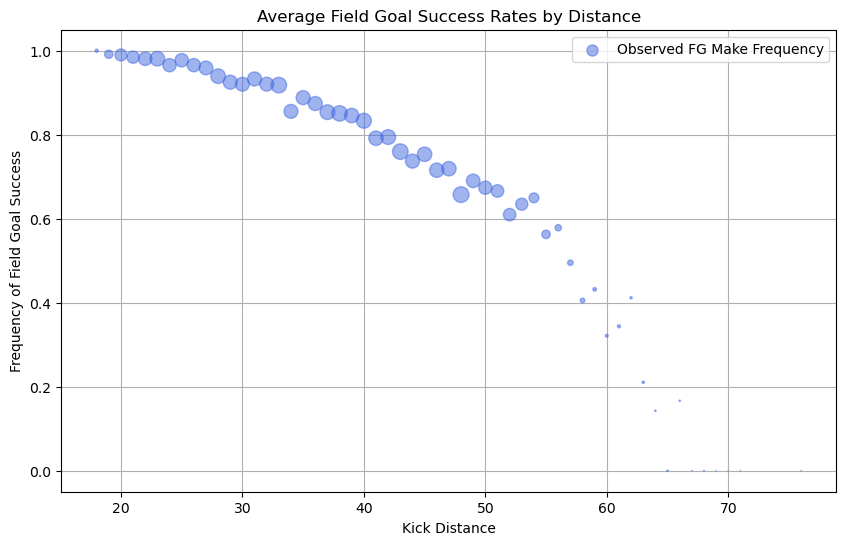

In [17]:
import matplotlib.pyplot as plt

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter plot
ax.scatter(x, y, color='royalblue', s=marker_sizes, label='Observed FG Make Frequency', alpha=0.5)

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Frequency of Field Goal Success')
ax.set_title('Average Field Goal Success Rates by Distance')
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Add gridlines
ax.grid()

# Show the plot
plt.show()

fig.savefig('../images/fg_obs_data.png', bbox_inches='tight', dpi=300)

/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


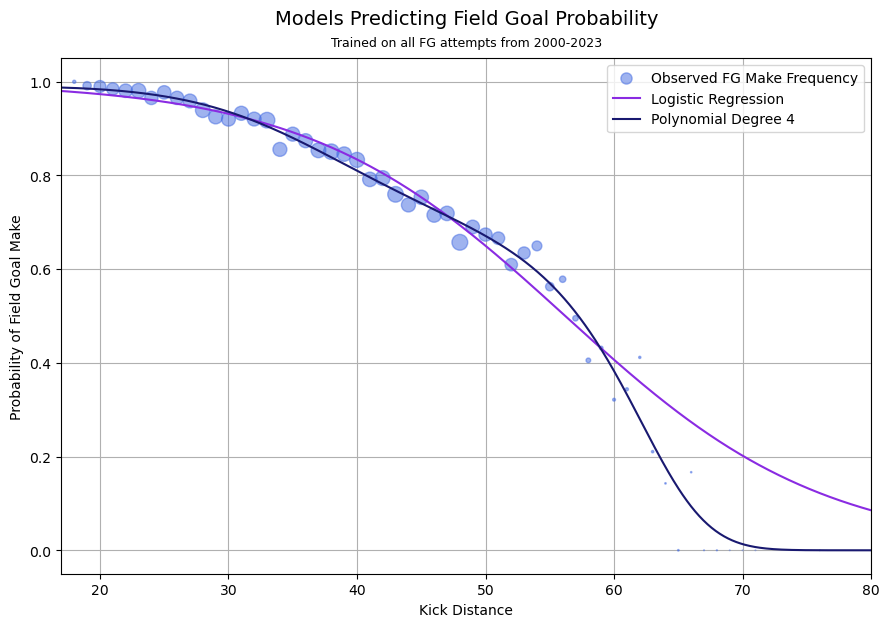

In [19]:
# Fit logistic regression model
X = df_fg_2000[['kick_distance']]
y = df_fg_2000['field_goal_made']
model = LogisticRegression()
model.fit(X, y)

# Fit polynomial logistic regression model
degree = 4
model_poly_4 = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
model_poly_4.fit(X, y)

# Generate values for plotting
x_values = np.linspace(0, 80, 1000)

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6.5))

# Plot the scatter plot
ax.scatter(x, y, color='royalblue', s=marker_sizes, label='Observed FG Make Frequency', alpha=0.5)

# Plot logistic regression predictions
y_values = model.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='blueviolet', label='Logistic Regression')

# Plot polynomial logistic regression predictions
y_values = model_poly_4.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='midnightblue', label='Polynomial Degree 4')

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Probability of Field Goal Make')
ax.set_title('Models Predicting Field Goal Probability', y=1.05, fontsize=14)

# add smaller text below title
ax.text(0.5, 1.03, 'Trained on all FG attempts from 2000-2023', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)

# Set legend
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Limit x axis to 17 to 80
ax.set_xlim([17, 80])

# Add gridlines
ax.grid()

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for subtitle
plt.show()

fig.savefig('../images/logit_and_poly_fg_model_fits.png', bbox_inches='tight', dpi=300)

In [20]:
df_fg['fg_proba'] = model_poly_4.predict_proba(df_fg[['kick_distance']])[:,1]

In [21]:
summary = df_fg.groupby(['kicker_player_id']).agg(
    earliest_season=('season', 'min'),
    latest_season=('season', 'max'),
    actual_makes=('field_goal_made', 'sum'),
    total_attempts=('field_goal_made', 'count'),
    expected_makes=('fg_proba', 'sum')
).reset_index()

# Step 2: Calculate the field goal percentage and expected field goal percentage
summary['actual_fg_pct'] = summary['actual_makes'] / summary['total_attempts']
summary['expected_fg_pct'] = summary['expected_makes'] / summary['total_attempts']

# Step 3: Calculate the field goal percentage over expectation
summary['fg_pct_over_expectation'] = summary['actual_fg_pct'] - summary['expected_fg_pct']

In [22]:
df_headshots = nfl.import_seasonal_rosters(years, columns=['season','player_name','player_id','headshot_url'])
df_headshots.sort_values(by='season', ascending=False, inplace=True)
df_headshots.drop_duplicates(subset='player_id', keep='first', inplace=True)
df_kickers = summary.merge(df_headshots, left_on='kicker_player_id', right_on='player_id', how='left')
df_kickers.head()

,kicker_player_id,earliest_season,latest_season,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation,season,player_name,player_id,headshot_url
0,00-0000108,2009,2013,165,205,172.064188,0.804878,0.839338,-0.034459,2013,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...
1,00-0001980,2009,2010,29,42,35.822056,0.690476,0.852906,-0.162430,2010,Kris Brown,00-0001980,https://static.www.nfl.com/image/private/f_aut...
2,00-0002655,2009,2010,18,23,20.618466,0.782609,0.896455,-0.113846,2010,John Carney,00-0002655,https://static.www.nfl.com/image/private/f_aut...
3,00-0004091,2009,2018,236,277,228.842983,0.851986,0.826148,0.025838,2018,Phil Dawson,00-0004091,https://static.www.nfl.com/image/private/f_aut...
4,00-0004811,2009,2009,12,19,16.122632,0.631579,0.848560,-0.216981,2009,Jason Elam,00-0004811,https://static.www.nfl.com/image/private/f_aut...


In [23]:
cols = ['player_name','headshot_url','total_attempts','actual_fg_pct','expected_fg_pct', 'fg_pct_over_expectation']
df_kickers = df_kickers[cols]

# fill missing headshot urls with a default image
default_img_url = 'https://static.www.nfl.com/image/private/f_auto,q_auto/league/rtnc0qkvhmkcwwueac0o'
df_kickers.headshot_url = df_kickers.headshot_url.fillna(default_img_url)

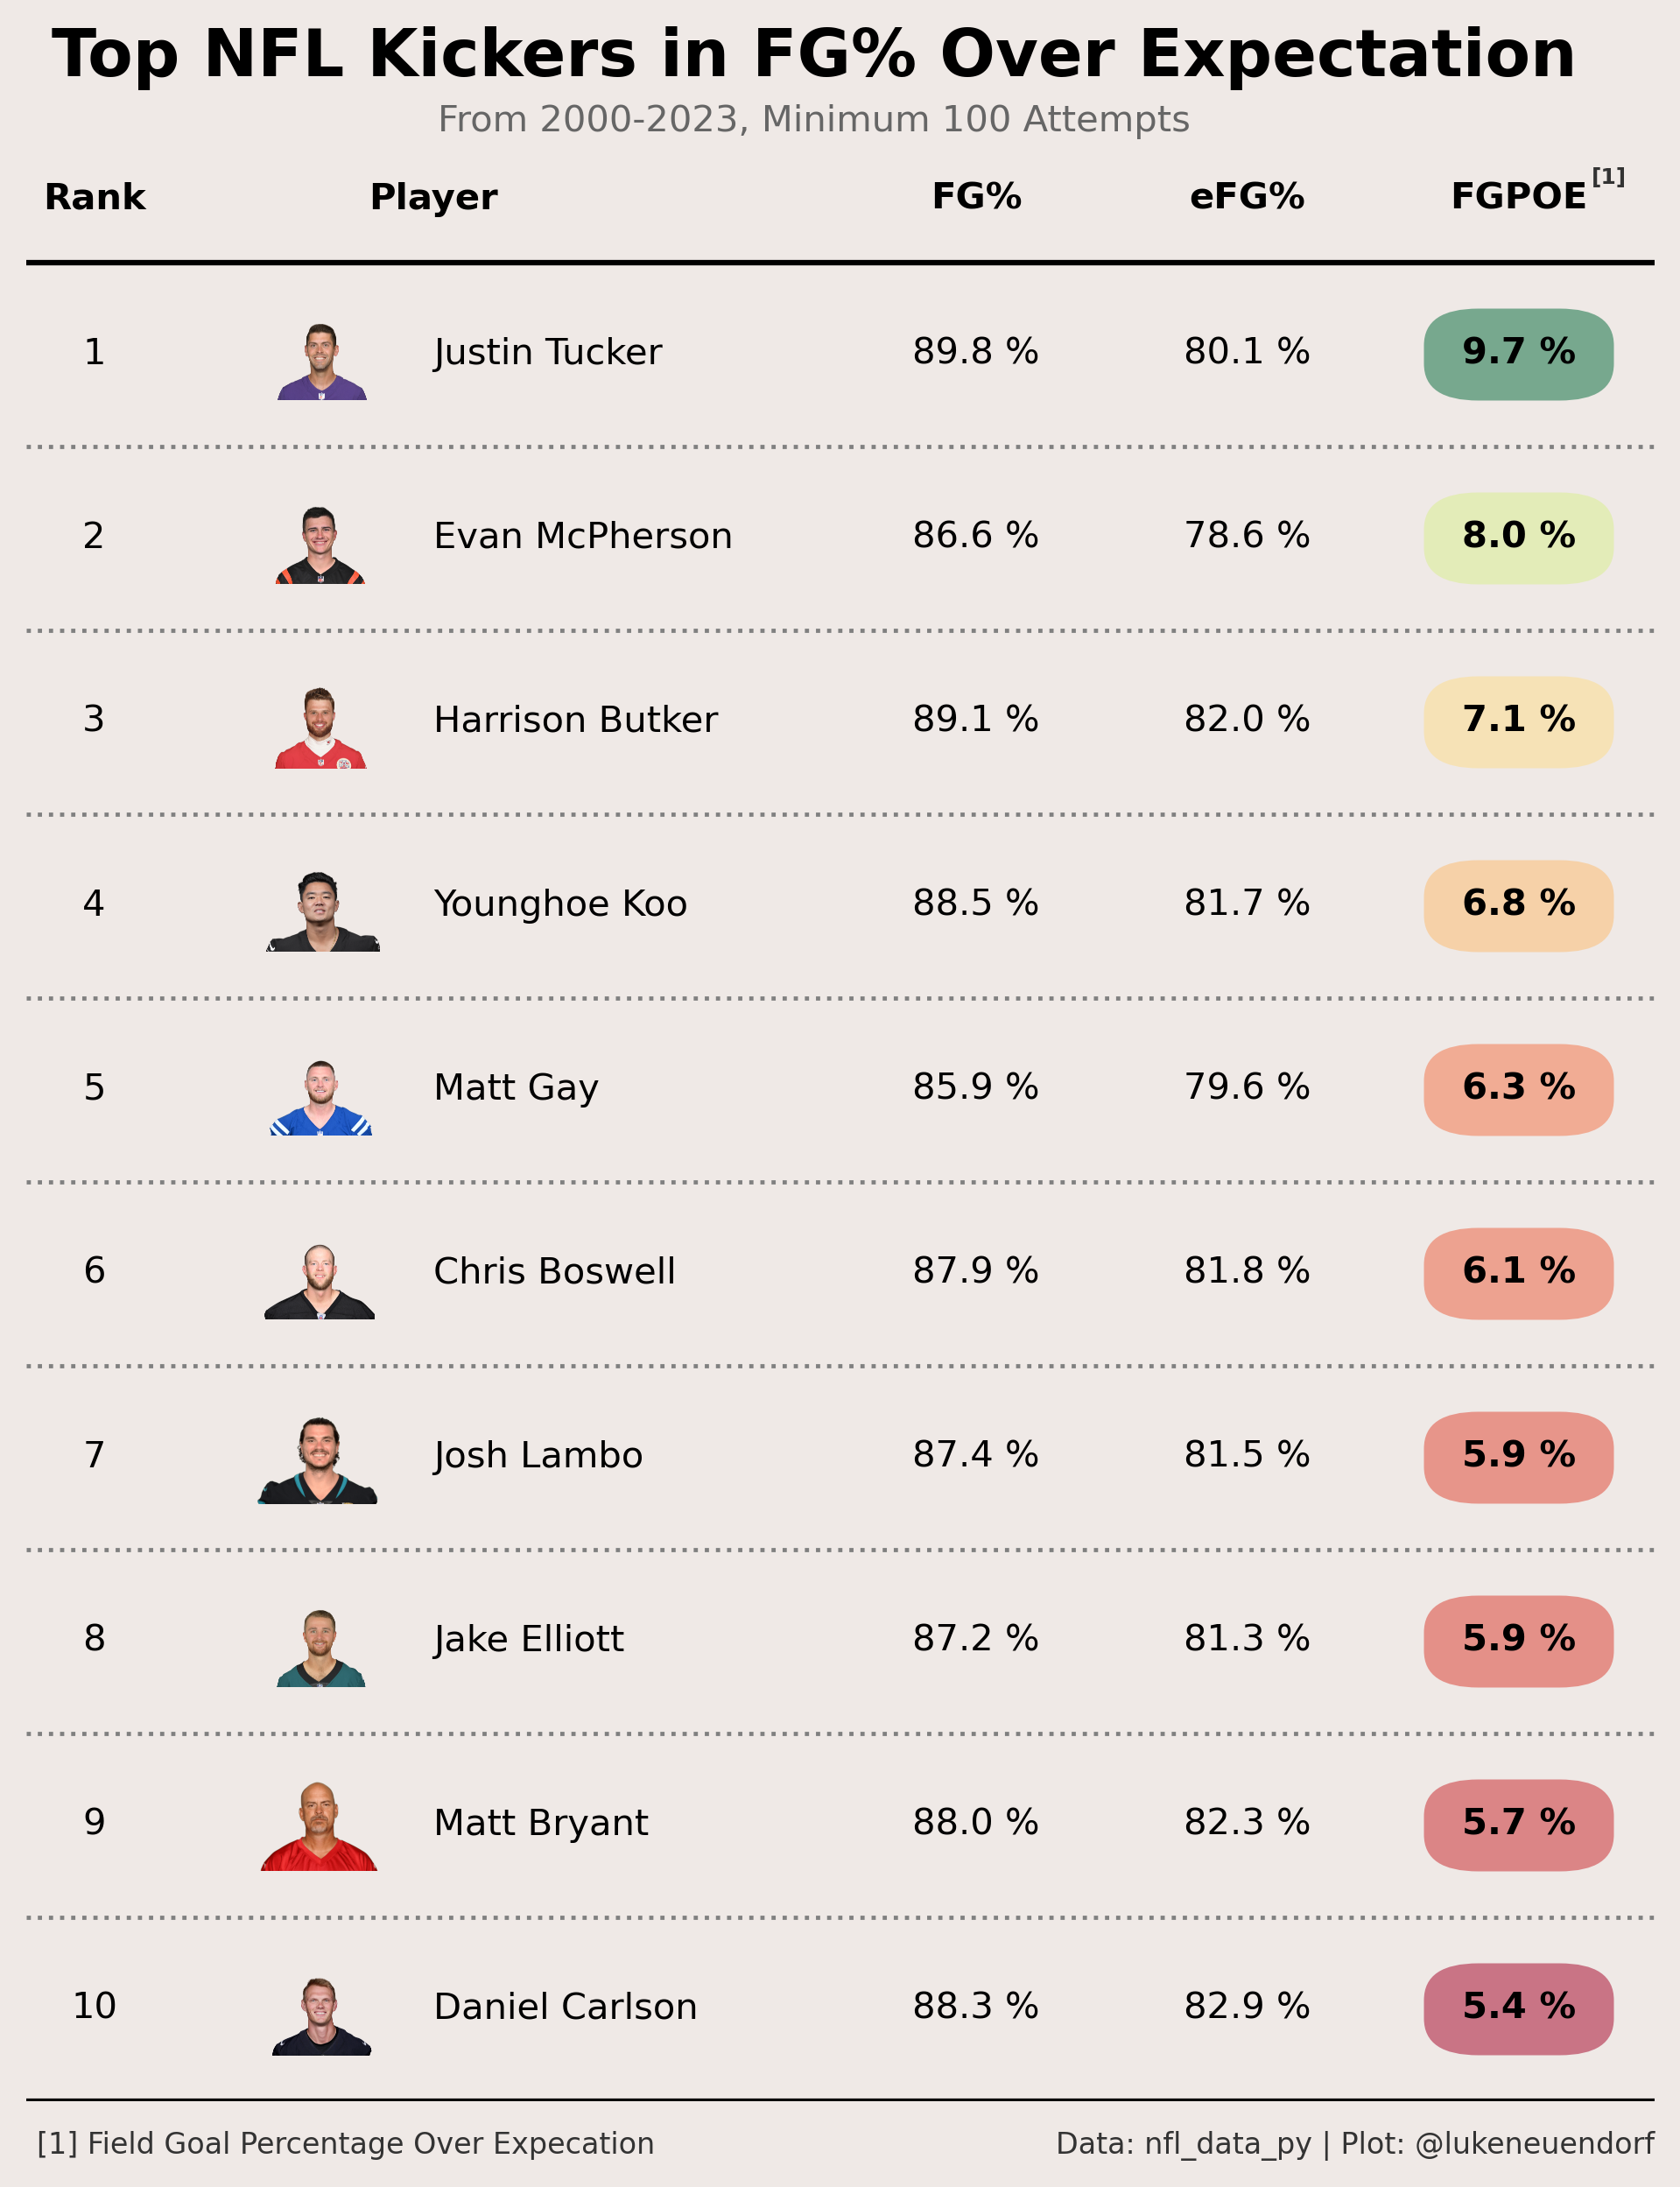

In [24]:
cache_dir = '../.cache/headshots'

os.makedirs(cache_dir, exist_ok=True)

# Data preparation
n_attempts = 100
n_players = 10
data = (df_kickers.query('total_attempts > @n_attempts')
                  .drop('total_attempts', axis=1)
                  .sort_values('fg_pct_over_expectation', ascending=False)
                  .head(n_players)
                  .reset_index(drop=True)
                  .reset_index()
                  .sort_values('fg_pct_over_expectation', ascending=True, ignore_index=True))

data['index'] = data['index'] + 1

def cache_image(url, cache_dir):
    """
    Downloads the image from the URL and saves it to the cache directory if not already cached.
    Returns the local file path of the cached image.
    """
    # Create a unique filename based on the URL using a hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    file_extension = url.split('.')[-1]
    # Check if the extension is reasonable, otherwise default to 'png'
    if file_extension.lower() not in ['jpg', 'jpeg', 'png']:
        file_extension = 'png'
    local_filename = f"{url_hash}.{file_extension}"
    local_path = os.path.join(cache_dir, local_filename)
    
    # Download the image if it does not exist in the cache
    if not os.path.exists(local_path):
        try:
            print(f"Downloading image from {url}")
            urllib.request.urlretrieve(url, local_path)
        except Exception as e:
            print(f"Failed to download image from {url}: {e}")
            # Provide a path to a default placeholder image
            local_path = 'default_placeholder_image.png'  # Ensure this file exists
    
    return local_path

def ax_logo(url, ax):
    # Get the local file path from the cache
    local_path = cache_image(url, cache_dir)
    
    try:
        headshot = Image.open(local_path)
        ax.imshow(headshot)
    except FileNotFoundError:
        print(f"File not found: {local_path}")
        # Optionally, you could add a placeholder or leave it empty if the image is missing.
        ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=10, color='red')
    
    ax.axis('off')
    return ax


# Set up figure and axis
fig = plt.figure(figsize=(8, 10), dpi=300, facecolor='#EFE9E6')
ax = plt.subplot()

ncols = 5
nrows = data.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 1.5, 3.5, 4.5, 5.5]
columns = ['index', 'player_name', 'actual_fg_pct', 'expected_fg_pct', 'fg_pct_over_expectation']

# Color scaling for FGPOE
min_fgpoe = data['fg_pct_over_expectation'].min()
max_fgpoe = data['fg_pct_over_expectation'].max()

def get_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    return plt.cm.RdYlGn(normalized)  # Red for low, Green for high

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'player_name':
            ha = 'left'
        else:
            ha = 'center'
        if column == 'fg_pct_over_expectation':
            value = data[column].iloc[i]
            color = get_color(value, min_fgpoe, max_fgpoe)
            
            # Add a rounded rectangle with the color behind the text
            rect_width = 0.6  # Width of the box
            rect_height = 0.4  # Height of the box
            rect_corner_radius = 0.2  # Radius for rounded corners
            rect = patches.FancyBboxPatch(
                (positions[j] - rect_width / 2, i + 0.5 - rect_height / 2), 
                width=rect_width, 
                height=rect_height,
                boxstyle=f"round,pad=0.05,rounding_size={rect_corner_radius}",
                linewidth=0, 
                edgecolor=None, 
                facecolor=color, 
                alpha=0.5, 
                zorder=2
            )
            ax.add_patch(rect)

            text_label = f'{value * 100:,.1f} %'
            weight = 'bold'
        elif column in ['actual_fg_pct', 'expected_fg_pct']:
            text_label = f'{data[column].iloc[i] * 100:,.1f} %'
            weight = 'normal'
        else:
            text_label = f'{data[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            zorder=3  # Ensure the text is above the colored box
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
# -- Add player images
for x in range(0, nrows):
    ax_coords = DC_to_NFC([.83, x+.25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(data['headshot_url'].iloc[x], flag_ax)

# -- Add column names
column_names = ['Rank', 'Player', 'FG%', 'eFG%', 'FGPOE']
for index, c in enumerate(column_names):
    if c == 'player_name':
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Top NFL Kickers in FG% Over Expectation', fontsize=18, weight='bold', color='black', y=.9)
fig.text(0.5, 0.86, 'From 2000-2023, Minimum 100 Attempts', fontsize=10, ha='center', color='#666666')

# Add the [1] footnote
fig.text(0.87, .84, '[1]', fontsize=6, ha='left', color='#333333', weight='bold')

# Add footer text (e.g., Twitter handle)
fig.text(0.13, .09, '[1] Field Goal Percentage Over Expecation', fontsize=8, ha='left', color='#333333')
fig.text(0.9, .09, 'Data: nfl_data_py | Plot: @lukeneuendorf', fontsize=8, ha='right', color='#333333')

# save to ../images
fig.savefig('../images/fg_pct_over_expectation_t10.png', bbox_inches='tight', dpi=300)

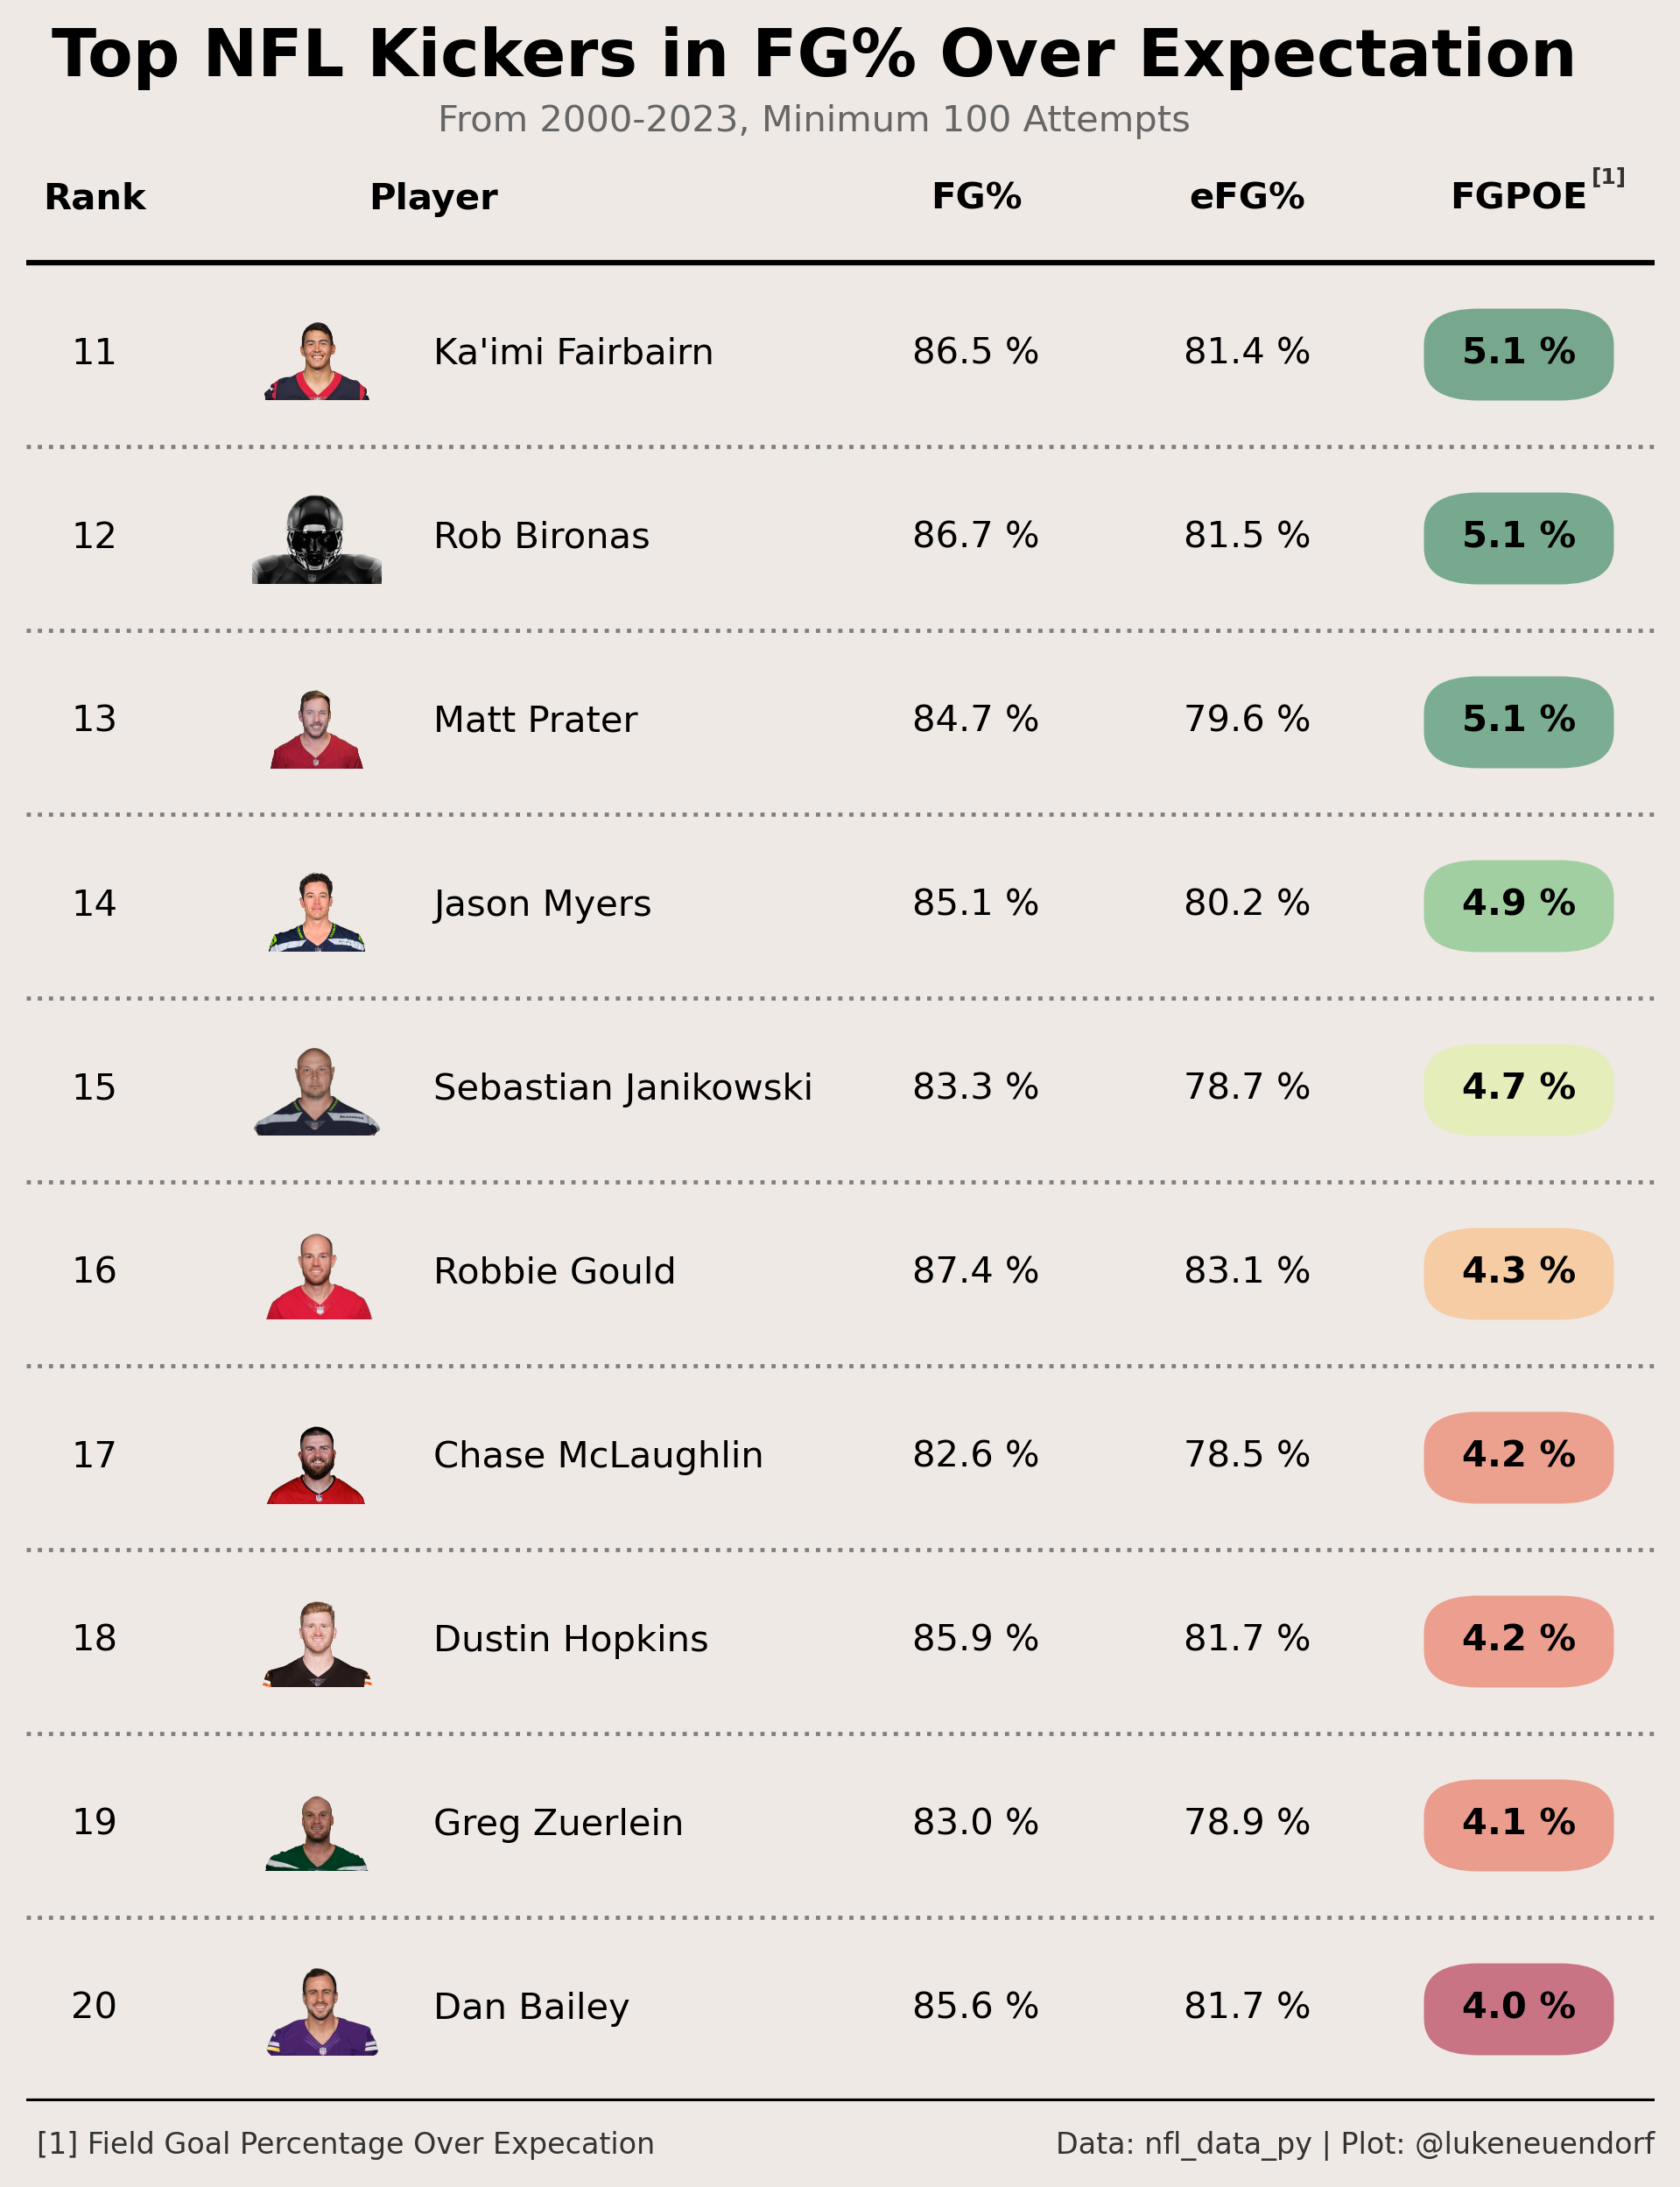

In [25]:
# Data preparation
n_attempts = 100
n_players = 10
data = (df_kickers.query('total_attempts > @n_attempts')
                  .drop('total_attempts', axis=1)
                  .sort_values('fg_pct_over_expectation', ascending=False)
                  .head(n_players + 10)
                  .reset_index(drop=True)
                  .reset_index()
                  .iloc[10:,:]  # Skip the top 10
                  .sort_values('fg_pct_over_expectation', ascending=True, ignore_index=True))

data['index'] = data['index'] + 1

def cache_image(url, cache_dir):
    """
    Downloads the image from the URL and saves it to the cache directory if not already cached.
    Returns the local file path of the cached image.
    """
    # Create a unique filename based on the URL using a hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    file_extension = url.split('.')[-1]
    # Check if the extension is reasonable, otherwise default to 'png'
    if file_extension.lower() not in ['jpg', 'jpeg', 'png']:
        file_extension = 'png'
    local_filename = f"{url_hash}.{file_extension}"
    local_path = os.path.join(cache_dir, local_filename)
    
    # Download the image if it does not exist in the cache
    if not os.path.exists(local_path):
        try:
            print(f"Downloading image from {url}")
            urllib.request.urlretrieve(url, local_path)
        except Exception as e:
            print(f"Failed to download image from {url}: {e}")
            # Provide a path to a default placeholder image
            local_path = 'default_placeholder_image.png'  # Ensure this file exists
    
    return local_path

def ax_logo(url, ax):
    # Get the local file path from the cache
    local_path = cache_image(url, cache_dir)
    
    try:
        headshot = Image.open(local_path)
        ax.imshow(headshot)
    except FileNotFoundError:
        print(f"File not found: {local_path}")
        # Optionally, you could add a placeholder or leave it empty if the image is missing.
        ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=10, color='red')
    
    ax.axis('off')
    return ax

# Set up figure and axis
fig = plt.figure(figsize=(8, 10), dpi=300, facecolor='#EFE9E6')
ax = plt.subplot()

ncols = 5
nrows = data.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 1.5, 3.5, 4.5, 5.5]
columns = ['index', 'player_name', 'actual_fg_pct', 'expected_fg_pct', 'fg_pct_over_expectation']

# Color scaling for FGPOE
min_fgpoe = data['fg_pct_over_expectation'].min()
max_fgpoe = data['fg_pct_over_expectation'].max()

def get_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    return plt.cm.RdYlGn(normalized)  # Red for low, Green for high

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'player_name':
            ha = 'left'
        else:
            ha = 'center'
        if column == 'fg_pct_over_expectation':
            value = data[column].iloc[i]
            color = get_color(value, min_fgpoe, max_fgpoe)
            
            # Add a rounded rectangle with the color behind the text
            rect_width = 0.6  # Width of the box
            rect_height = 0.4  # Height of the box
            rect_corner_radius = 0.2  # Radius for rounded corners
            rect = patches.FancyBboxPatch(
                (positions[j] - rect_width / 2, i + 0.5 - rect_height / 2), 
                width=rect_width, 
                height=rect_height,
                boxstyle=f"round,pad=0.05,rounding_size={rect_corner_radius}",
                linewidth=0, 
                edgecolor=None, 
                facecolor=color, 
                alpha=0.5, 
                zorder=2
            )
            ax.add_patch(rect)

            text_label = f'{value * 100:,.1f} %'
            weight = 'bold'
        elif column in ['actual_fg_pct', 'expected_fg_pct']:
            text_label = f'{data[column].iloc[i] * 100:,.1f} %'
            weight = 'normal'
        else:
            text_label = f'{data[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            zorder=3  # Ensure the text is above the colored box
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
# -- Add player images
for x in range(0, nrows):
    ax_coords = DC_to_NFC([.82, x+.25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(data['headshot_url'].iloc[x], flag_ax)

# -- Add column names
column_names = ['Rank', 'Player', 'FG%', 'eFG%', 'FGPOE']
for index, c in enumerate(column_names):
    if c == 'player_name':
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Top NFL Kickers in FG% Over Expectation', fontsize=18, weight='bold', color='black', y=.9)
fig.text(0.5, 0.86, 'From 2000-2023, Minimum 100 Attempts', fontsize=10, ha='center', color='#666666')

# Add the [1] footnote
fig.text(0.87, .84, '[1]', fontsize=6, ha='left', color='#333333', weight='bold')

# Add footer text (e.g., Twitter handle)
fig.text(0.13, .09, '[1] Field Goal Percentage Over Expecation', fontsize=8, ha='left', color='#333333')
fig.text(0.9, .09, 'Data: nfl_data_py | Plot: @lukeneuendorf', fontsize=8, ha='right', color='#333333')

fig.savefig('../images/fg_pct_over_expectation_t20.png', bbox_inches='tight', dpi=300)

In [ ]:
df_fg.head()

,season,game_id,play_id,kicker_player_name,kicker_player_id,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,elevation,field_goal_made,fg_proba
0,2000,2000_01_ARI_NYG,2771.0,C.Blanchard,00-0001343,32.0,905.0,3.0,80.0,-14.0,0,0,0,0,1,1,2,1,0.916383
1,2000,2000_01_BAL_PIT,467.0,M.Stover,00-0015784,23.0,3201.0,8.0,74.0,0.0,0,0,0,0,0,0,223,1,0.976624
2,2000,2000_01_BAL_PIT,1810.0,M.Stover,00-0015784,26.0,1811.0,8.0,74.0,10.0,0,0,0,0,0,0,223,1,0.964119
3,2000,2000_01_BAL_PIT,2027.0,M.Stover,00-0015784,33.0,1800.0,8.0,74.0,13.0,0,0,0,0,0,0,223,1,0.905149
4,2000,2000_01_BAL_PIT,2250.0,K.Brown,00-0001980,45.0,1591.0,8.0,74.0,-16.0,0,0,0,1,0,0,223,0,0.740813


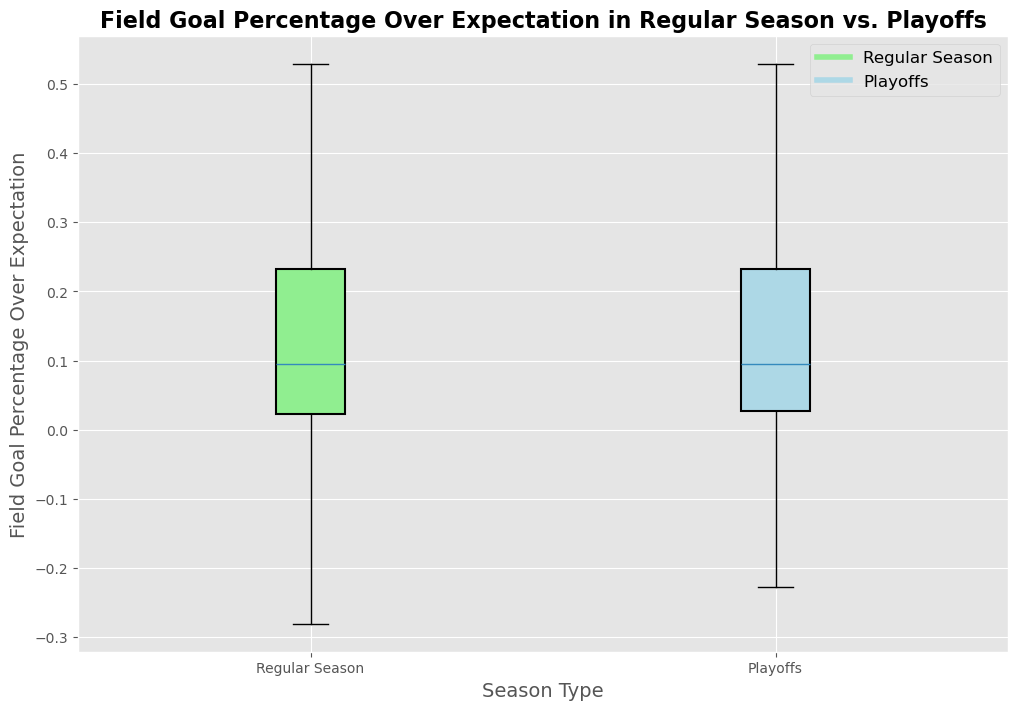

In [26]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
playoffs = df_fg.query('postseason == 1')
regular_season = df_fg.query('postseason == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [regular_season['fg_pct_over_expectation'], playoffs['fg_pct_over_expectation']],
    tick_labels=['Regular Season', 'Playoffs'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation in Regular Season vs. Playoffs', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)
ax.set_xlabel('Season Type', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Regular Season'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Playoffs')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

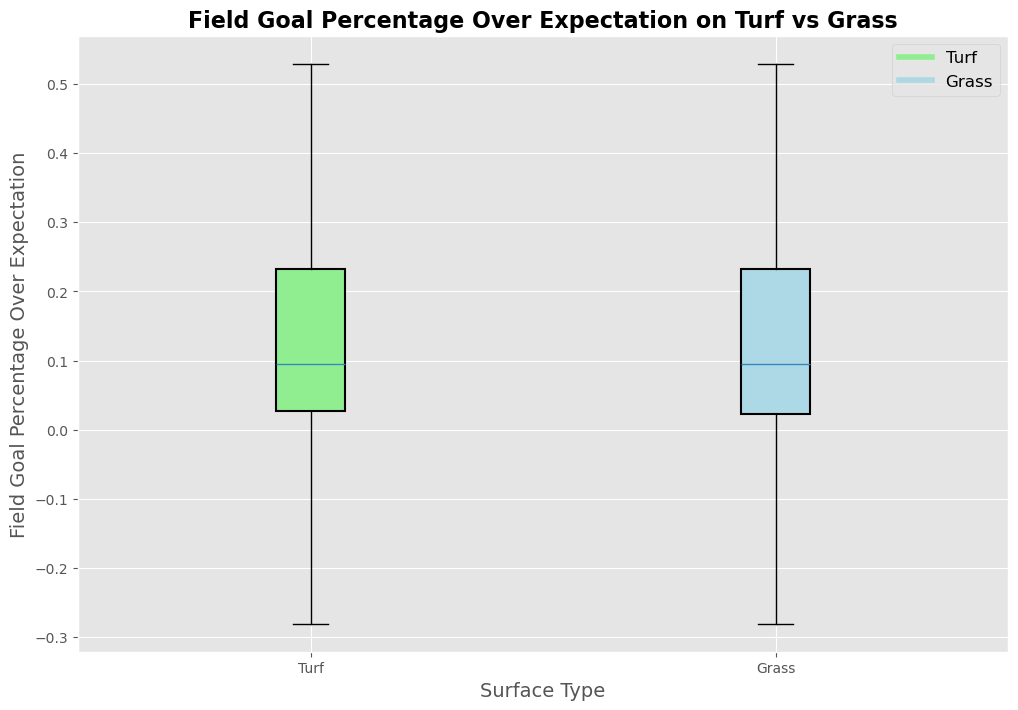

In [27]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
grass = df_fg.query('grass_surface == 1')
turf = df_fg.query('grass_surface == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [turf['fg_pct_over_expectation'], grass['fg_pct_over_expectation']],
    tick_labels=['Turf', 'Grass'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation on Turf vs Grass', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)
ax.set_xlabel('Surface Type', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Turf'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Grass')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

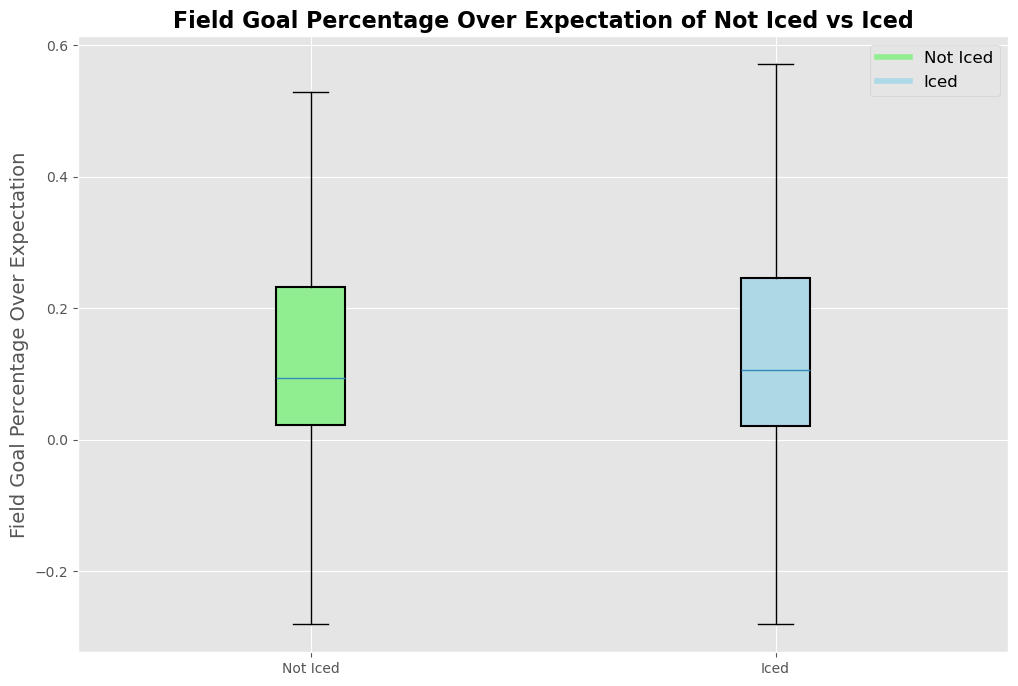

In [28]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
iced = df_fg.query('iced == 1')
not_iced = df_fg.query('iced == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [not_iced['fg_pct_over_expectation'], iced['fg_pct_over_expectation']],
    tick_labels=['Not Iced', 'Iced'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation of Not Iced vs Iced', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Not Iced'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Iced')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

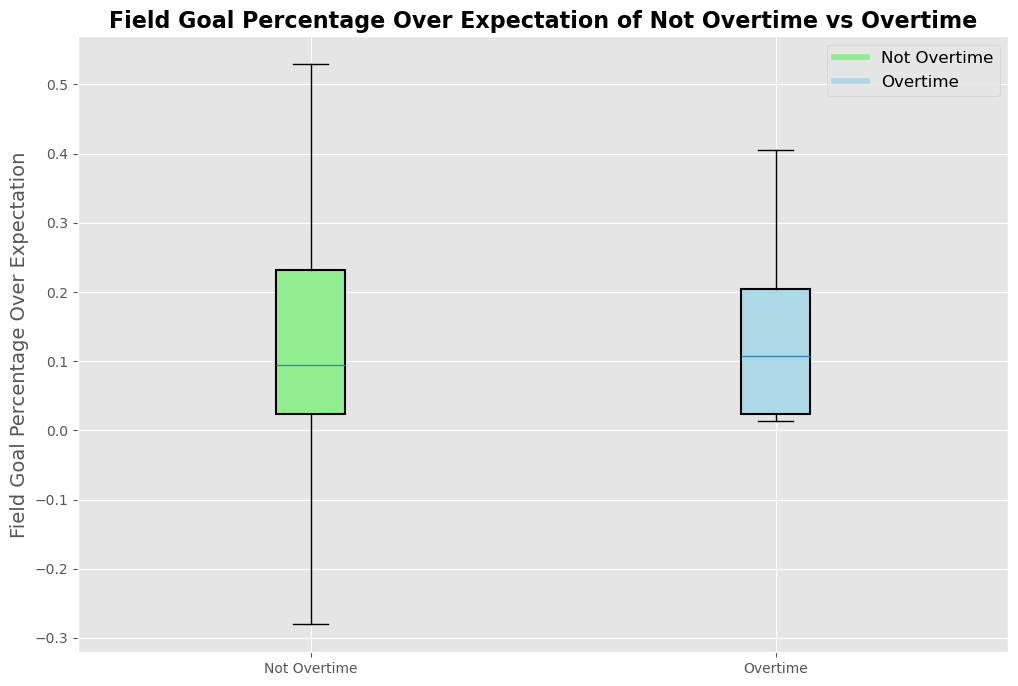

In [29]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
overtime = df_fg.query('overtime == 1')
not_overtime = df_fg.query('overtime == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [not_overtime['fg_pct_over_expectation'], overtime['fg_pct_over_expectation']],
    tick_labels=['Not Overtime', 'Overtime'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation of Not Overtime vs Overtime', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Not Overtime'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Overtime')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

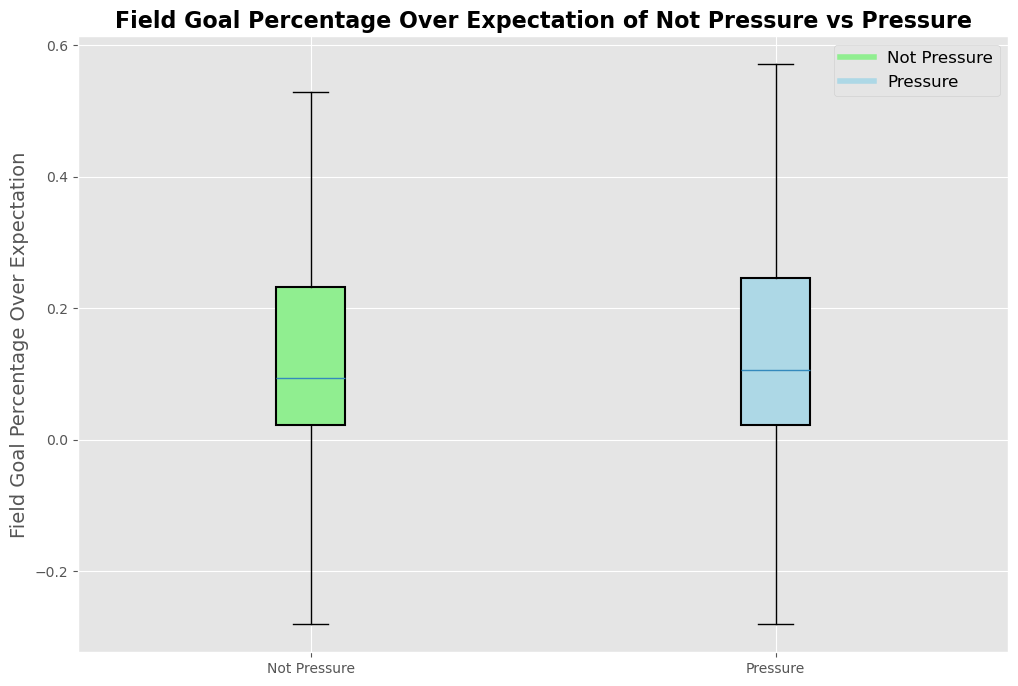

In [30]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
pressure_situation = df_fg.query('pressure_situation == 1')
not_pressure_situation = df_fg.query('pressure_situation == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [not_pressure_situation['fg_pct_over_expectation'], pressure_situation['fg_pct_over_expectation']],
    tick_labels=['Not Pressure', 'Pressure'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation of Not Pressure vs Pressure', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Not Pressure'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Pressure')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

In [ ]:
df_fg.sort_values(['game_id', 'play_id'], inplace=True, ignore_index=True)

# Calculate the field goal percentage over expectation for each kicker for their last n kicks
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']

# Function to calculate rolling mean excluding the current row
def rolling_mean_exclude_current(x, n):
    return x.rolling(window = n, min_periods=n).mean().shift(1)

df_fg['FGPOE_L10'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 10))
df_fg['FGPOE_L20'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 20))
df_fg['FGPOE_L30'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 30))
df_fg['FGPOE_L35'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 35))
df_fg['FGPOE_L40'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 40))
df_fg['FGPOE_L50'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 50))
df_fg['FGPOE_L75'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 75))
df_fg['FGPOE_L100'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 100))


def expanding_mean_exclude_current(x):
    return x.expanding(min_periods=25).mean().shift(1)

# Calculate career average of all kicks prior to each kick
df_fg['career_fg_pct_over_expectation'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(expanding_mean_exclude_current)

In [ ]:

print('L10:', round(df_fg.query('season >= 2010').FGPOE_L10.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L20:', round(df_fg.query('season >= 2010').FGPOE_L20.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L30:', round(df_fg.query('season >= 2010').FGPOE_L30.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L35:', round(df_fg.query('season >= 2010').FGPOE_L35.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L40:', round(df_fg.query('season >= 2010').FGPOE_L40.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L50:', round(df_fg.query('season >= 2010').FGPOE_L50.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L75:', round(df_fg.query('season >= 2010').FGPOE_L75.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L100:', round(df_fg.query('season >= 2010').FGPOE_L100.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))


L10: 4.9
L20: 8.85
L30: 12.56
L35: 14.42
L40: 16.14
L50: 19.33
L75: 26.73
L100: 34.03


In [ ]:
df_fg.query('season==2023').kicker_player_name.value_counts()

kicker_player_name
H.Butker        46
J.Myers         42
M.Gay           41
J.Tucker        40
B.Aubrey        39
G.Zuerlein      38
C.Santos        38
Y.Koo           37
B.McManus       37
B.Grupe         37
C.McLaughlin    36
D.Hopkins       36
A.Carlson       36
W.Lutz          34
T.Bass          34
J.Elliott       33
J.Moody         33
C.Dicker        33
M.Prater        33
C.Boswell       32
K.Fairbairn     31
E.McPherson     31
D.Carlson       30
N.Folk          30
G.Joseph        30
E.Pineiro       29
J.Sanders       28
B.Maher         26
C.Ryland        25
J.Slye          24
L.Havrisik      20
R.Patterson     18
G.Gano          17
M.Ammendola      9
M.Badgley        7
M.Crosby         7
R.Bullock        6
A.Seibert        1
D.Ogunbowale     1
J.Gillan         1
M.Wright         1
Name: count, dtype: int64

In [ ]:
df_fg.query('kicker_player_name == "B.Aubrey"')

,season,game_id,play_id,kicker_player_name,kicker_player_id,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,elevation,field_goal_made,fg_proba,fg_pct_over_expectation,pressure_situation,FGPOE_L10,FGPOE_L20,FGPOE_L30,FGPOE_L40,FGPOE_L50,FGPOE_L75,FGPOE_L100,FGPOE_L35,career_fg_pct_over_expectation
23383,2023,2023_01_DAL_NYG,704.0,B.Aubrey,00-0037692,21.0,2904.0,0.0,70.0,6.0,1,0,0,0,0,0,2,1,0.981959,0.018041,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23384,2023,2023_01_DAL_NYG,1256.0,B.Aubrey,00-0037692,38.0,2460.0,0.0,70.0,16.0,0,0,0,0,0,0,2,1,0.838848,0.161152,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23479,2023,2023_02_NYJ_DAL,1162.0,B.Aubrey,00-0037692,35.0,2354.0,0.0,70.0,7.0,0,0,0,1,0,0,173,1,0.880282,0.119718,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23481,2023,2023_02_NYJ_DAL,2650.0,B.Aubrey,00-0037692,21.0,1347.0,0.0,70.0,8.0,0,0,0,1,0,0,173,1,0.981959,0.018041,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23482,2023,2023_02_NYJ_DAL,2872.0,B.Aubrey,00-0037692,55.0,1224.0,0.0,70.0,11.0,0,0,0,1,0,0,173,1,0.569928,0.430072,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23483,2023,2023_02_NYJ_DAL,3324.0,B.Aubrey,00-0037692,26.0,747.0,0.0,70.0,14.0,0,0,0,1,0,0,173,1,0.964119,0.035881,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23484,2023,2023_02_NYJ_DAL,3616.0,B.Aubrey,00-0037692,30.0,502.0,0.0,70.0,17.0,0,0,0,1,0,0,173,1,0.936077,0.063923,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23522,2023,2023_03_DAL_ARI,908.0,B.Aubrey,00-0037692,49.0,2812.0,0.0,70.0,-9.0,0,0,0,0,1,1,326,1,0.686036,0.313964,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23525,2023,2023_03_DAL_ARI,2852.0,B.Aubrey,00-0037692,27.0,1470.0,0.0,70.0,-11.0,0,0,0,0,1,1,326,1,0.958454,0.041546,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23526,2023,2023_03_DAL_ARI,3810.0,B.Aubrey,00-0037692,26.0,576.0,0.0,70.0,-8.0,0,0,0,0,1,1,326,1,0.964119,0.035881,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
round(df_fg.query('kicker_player_name == "B.Aubrey"').iloc[:-3].fg_pct_over_expectation.mean(),6)

0.155061

In [ ]:
df_fg.head()

,season,game_id,play_id,kicker_player_name,kicker_player_id,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,elevation,field_goal_made,fg_proba,fg_pct_over_expectation,pressure_situation,FGPOE_L10,FGPOE_L20,FGPOE_L30,FGPOE_L40,FGPOE_L50,FGPOE_L75,FGPOE_L100,FGPOE_L35,career_fg_pct_over_expectation
0,2000,2000_01_ARI_NYG,2771.0,C.Blanchard,00-0001343,32.0,905.0,3.0,80.0,-14.0,0,0,0,0,1,1,2,1,0.916383,0.083617,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2000_01_BAL_PIT,467.0,M.Stover,00-0015784,23.0,3201.0,8.0,74.0,0.0,0,0,0,0,0,0,223,1,0.976624,0.023376,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,2000_01_BAL_PIT,1810.0,M.Stover,00-0015784,26.0,1811.0,8.0,74.0,10.0,0,0,0,0,0,0,223,1,0.964119,0.035881,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,2000_01_BAL_PIT,2027.0,M.Stover,00-0015784,33.0,1800.0,8.0,74.0,13.0,0,0,0,0,0,0,223,1,0.905149,0.094851,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,2000_01_BAL_PIT,2250.0,K.Brown,00-0001980,45.0,1591.0,8.0,74.0,-16.0,0,0,0,1,0,0,223,0,0.740813,-0.740813,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# TODO: add rain as a feature (and maybe snow)